In [1]:
sc.version

'2.4.5'

In [2]:
df = sqlContext.read.format('csv').options(header='true', inferschema='true')\
    .load('../Iris.csv')
df.rdd.take(3)

[Row(Id=1, SepalLengthCm=5.1, SepalWidthCm=3.5, PetalLengthCm=1.4, PetalWidthCm=0.2, Species='Iris-setosa'),
 Row(Id=2, SepalLengthCm=4.9, SepalWidthCm=3.0, PetalLengthCm=1.4, PetalWidthCm=0.2, Species='Iris-setosa'),
 Row(Id=3, SepalLengthCm=4.7, SepalWidthCm=3.2, PetalLengthCm=1.3, PetalWidthCm=0.2, Species='Iris-setosa')]

In [3]:
#1. Preparación de datos
# Feature selection
df2=df.select('SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm','Species')
#df2.show()

In [4]:
df2.groupBy("Species").count().show()

+---------------+-----+
|        Species|count|
+---------------+-----+
| Iris-virginica|   50|
|    Iris-setosa|   50|
|Iris-versicolor|   50|
+---------------+-----+



In [35]:
#2 formateo de los datos para spark

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

labelIndexer = StringIndexer(inputCol = "Species", outputCol = "indexedLabel").fit(df2)

# Solo para mostrar
indexedx = labelIndexer.transform(df2)

In [36]:
indexedx.toPandas()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,indexedLabel
0,5.1,3.5,1.4,0.2,Iris-setosa,0.0
1,4.9,3.0,1.4,0.2,Iris-setosa,0.0
2,4.7,3.2,1.3,0.2,Iris-setosa,0.0
3,4.6,3.1,1.5,0.2,Iris-setosa,0.0
4,5.0,3.6,1.4,0.2,Iris-setosa,0.0
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica,2.0
146,6.3,2.5,5.0,1.9,Iris-virginica,2.0
147,6.5,3.0,5.2,2.0,Iris-virginica,2.0
148,6.2,3.4,5.4,2.3,Iris-virginica,2.0


In [37]:
from pyspark.ml.feature import VectorAssembler
fea=["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]
featureAssembler = VectorAssembler(inputCols=fea, outputCol="indexedFeatures")

#solo para mostrar
dfa = featureAssembler.transform(df2) # this will add to the table outputCol column with vectors.
dfa.show()# dfa ya no es necesario, ahora se encarga Pipeline

+-------------+------------+-------------+------------+-----------+-----------------+
|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|    Species|  indexedFeatures|
+-------------+------------+-------------+------------+-----------+-----------------+
|          5.1|         3.5|          1.4|         0.2|Iris-setosa|[5.1,3.5,1.4,0.2]|
|          4.9|         3.0|          1.4|         0.2|Iris-setosa|[4.9,3.0,1.4,0.2]|
|          4.7|         3.2|          1.3|         0.2|Iris-setosa|[4.7,3.2,1.3,0.2]|
|          4.6|         3.1|          1.5|         0.2|Iris-setosa|[4.6,3.1,1.5,0.2]|
|          5.0|         3.6|          1.4|         0.2|Iris-setosa|[5.0,3.6,1.4,0.2]|
|          5.4|         3.9|          1.7|         0.4|Iris-setosa|[5.4,3.9,1.7,0.4]|
|          4.6|         3.4|          1.4|         0.3|Iris-setosa|[4.6,3.4,1.4,0.3]|
|          5.0|         3.4|          1.5|         0.2|Iris-setosa|[5.0,3.4,1.5,0.2]|
|          4.4|         2.9|          1.4|         0.2

In [38]:
from pyspark.ml import Pipeline

#pipeline = Pipeline(stages=[featureAssembler, labelIndexer])
# Fit the pipeline to training documents.
#pipelineFit = pipeline.fit(df2)
#dataset = pipelineFit.transform(df2)
#dataset.show(5)

In [39]:
#3 distribucion de los datos
# set seed for reproducibility
(trainingData, testData) = df2.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 103
Test Dataset Count: 47


In [18]:
#trainingData.toPandas().to_csv("trainingData.csv")
#testData.toPandas().to_csv("testData.csv")

In [63]:
#4. Modelamiento (con un modelo ML)
# Fit Decision Tree Classification Model
from pyspark.ml.classification import DecisionTreeClassifier
# Instancia model
dTree = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')
stringIndexer.labels

['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

In [118]:
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureAssembler, dTree, labelConverter]) #

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)
#solo para mostrar
df3 = model.transform(trainingData)

In [119]:
df3.select("indexedFeatures","indexedLabel","Species").show() #,"predictedLabel"

+-----------------+------------+---------------+
|  indexedFeatures|indexedLabel|        Species|
+-----------------+------------+---------------+
|[4.3,3.0,1.1,0.1]|         0.0|    Iris-setosa|
|[4.4,2.9,1.4,0.2]|         0.0|    Iris-setosa|
|[4.4,3.0,1.3,0.2]|         0.0|    Iris-setosa|
|[4.4,3.2,1.3,0.2]|         0.0|    Iris-setosa|
|[4.6,3.1,1.5,0.2]|         0.0|    Iris-setosa|
|[4.6,3.2,1.4,0.2]|         0.0|    Iris-setosa|
|[4.7,3.2,1.6,0.2]|         0.0|    Iris-setosa|
|[4.8,3.0,1.4,0.1]|         0.0|    Iris-setosa|
|[4.8,3.0,1.4,0.3]|         0.0|    Iris-setosa|
|[4.8,3.1,1.6,0.2]|         0.0|    Iris-setosa|
|[4.8,3.4,1.6,0.2]|         0.0|    Iris-setosa|
|[4.9,2.4,3.3,1.0]|         1.0|Iris-versicolor|
|[4.9,2.5,4.5,1.7]|         2.0| Iris-virginica|
|[4.9,3.1,1.5,0.1]|         0.0|    Iris-setosa|
|[5.0,2.0,3.5,1.0]|         1.0|Iris-versicolor|
|[5.0,2.3,3.3,1.0]|         1.0|Iris-versicolor|
|[5.0,3.0,1.6,0.2]|         0.0|    Iris-setosa|
|[5.0,3.4,1.5,0.2]| 

In [120]:
#model.write().overwrite().save('final_dt_model_trained')

In [121]:
model.stages[-2] # cambiar para -2 de ser necesario

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_0afbe144e78b) of depth 5 with 17 nodes

In [122]:
model.stages[-2].featureImportances

SparseVector(4, {0: 0.0479, 1: 0.0146, 2: 0.5215, 3: 0.4161})

In [123]:
# Revisando el comportamiento de los datos: Caracteristicas mas importantes
df3.schema["indexedFeatures"].metadata["ml_attr"]["attrs"]

{'numeric': [{'idx': 0, 'name': 'SepalLengthCm'},
  {'idx': 1, 'name': 'SepalWidthCm'},
  {'idx': 2, 'name': 'PetalLengthCm'},
  {'idx': 3, 'name': 'PetalWidthCm'}]}

In [124]:
import pandas as pd

def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [125]:
feature_importances = ExtractFeatureImp(model.stages[-2].featureImportances, df3, "indexedFeatures").head(10)
feature_importances

,idx,name,score
2,2,PetalLengthCm,0.521473
3,3,PetalWidthCm,0.416065
0,0,SepalLengthCm,0.047861
1,1,SepalWidthCm,0.014602


In [126]:
model.stages[-2]

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_0afbe144e78b) of depth 5 with 17 nodes

Text(0.5, 1.0, 'Feature Importances')

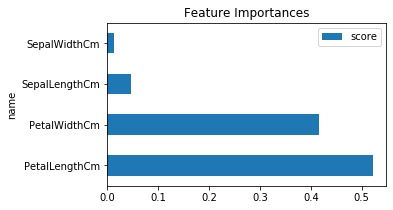

In [127]:
import matplotlib.pyplot as plt

#https://ashwin-ks.github.io/2018-07-05-Pyspark-ML-Classification/
feat_imp_df = pd.DataFrame(feature_importances).sort_values(by=['score'],ascending=False)
feat_imp_df.drop(columns=['idx'],inplace=True)
feat_imp_df.set_index('name',inplace=True)
feat_imp_df.head(20).plot(kind='barh',figsize=(5,3))
plt.title('Feature Importances')

In [128]:
#4.2 Make predictions.
predictions = model.transform(testData)

In [133]:
# Select example rows to display.
#predictions.select("indexedFeatures","Species","predictedLabel").show(5)
# Select example rows to display.
#predictions.select("prediction", "indexedLabel", "indexedFeatures").collect()
predictions.select("predictedLabel", "Species").show()

+---------------+---------------+
| predictedLabel|        Species|
+---------------+---------------+
|    Iris-setosa|    Iris-setosa|
|    Iris-setosa|    Iris-setosa|
|    Iris-setosa|    Iris-setosa|
|    Iris-setosa|    Iris-setosa|
|    Iris-setosa|    Iris-setosa|
|    Iris-setosa|    Iris-setosa|
|    Iris-setosa|    Iris-setosa|
|    Iris-setosa|    Iris-setosa|
|    Iris-setosa|    Iris-setosa|
|    Iris-setosa|    Iris-setosa|
|    Iris-setosa|    Iris-setosa|
|    Iris-setosa|    Iris-setosa|
|    Iris-setosa|    Iris-setosa|
|    Iris-setosa|    Iris-setosa|
|    Iris-setosa|    Iris-setosa|
|    Iris-setosa|    Iris-setosa|
|    Iris-setosa|    Iris-setosa|
|Iris-versicolor|Iris-versicolor|
|    Iris-setosa|    Iris-setosa|
|Iris-versicolor|Iris-versicolor|
+---------------+---------------+
only showing top 20 rows



In [ ]:
from pyspark.ml import PipelineModel

#modelrec = PipelineModel.load('final_dt_model_trained')
#preds = modelrec.transform(testData)
#preds.select("predictedLabel","State").show(5)

In [134]:
# 4.3 Evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % (accuracy))
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[-2]
print(rfModel)  # summary only

Accuracy = 0.978723
Test Error = 0.0212766
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_0afbe144e78b) of depth 5 with 17 nodes


In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
